Ben Gutstein

Homework 1: Aircraft Inventory

Data Eng 300

Task 1:

In [2]:
import pandas as pd
df = pd.read_csv('/content/T_F41SCHEDULE_B43.csv')

<ipython-input-2-5c56377932bc>:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/T_F41SCHEDULE_B43.csv')


In [3]:
columns_to_check = [
    'CARRIER', 'CARRIER_NAME', 'MANUFACTURE_YEAR',
    'NUMBER_OF_SEATS', 'CAPACITY_IN_POUNDS', 'AIRLINE_ID'
]

missing_summary = df[columns_to_check].isnull().sum().to_frame(name='Missing_Count')
missing_summary['Missing_%'] = (missing_summary['Missing_Count'] / len(df)) * 100
missing_summary

,Missing_Count,Missing_%
CARRIER,49,0.037033
CARRIER_NAME,105,0.079357
MANUFACTURE_YEAR,3,0.002267
NUMBER_OF_SEATS,7,0.005290
CAPACITY_IN_POUNDS,101,0.076334
AIRLINE_ID,105,0.079357


In [5]:
df[df['CARRIER'].isnull()][['CARRIER_NAME', 'UNIQUE_CARRIER']].drop_duplicates()

df[df['MANUFACTURE_YEAR'].isnull()][['MODEL', 'MANUFACTURER']]

df.groupby('MODEL')[['NUMBER_OF_SEATS', 'CAPACITY_IN_POUNDS']].median()

carrier_airline_map = df[['CARRIER', 'AIRLINE_ID']].dropna().drop_duplicates()

In [6]:
# Check where CARRIER is missing but CARRIER_NAME is not
carrier_inference = df[df['CARRIER'].isnull()][['CARRIER_NAME', 'UNIQUE_CARRIER']].drop_duplicates()

# Check if AIRLINE_ID is predictable from CARRIER
carrier_to_airline = df[['CARRIER', 'AIRLINE_ID']].dropna().drop_duplicates()

# Median imputation by MODEL
median_vals = df.groupby('MODEL')[['NUMBER_OF_SEATS', 'CAPACITY_IN_POUNDS']].median()

In [7]:
# Fill in CARRIER based on UNIQUE_CARRIER where possible
df['CARRIER'] = df['CARRIER'].fillna(df['UNIQUE_CARRIER'])

# Fill in AIRLINE_ID based on CARRIER using the map
carrier_airline_dict = carrier_to_airline.set_index('CARRIER')['AIRLINE_ID'].to_dict()
df['AIRLINE_ID'] = df.apply(lambda row: carrier_airline_dict.get(row['CARRIER']) if pd.isna(row['AIRLINE_ID']) else row['AIRLINE_ID'], axis=1)

# Fill in MANUFACTURE_YEAR using the most frequent year per model (could also do median)
year_mode_by_model = df.groupby('MODEL')['MANUFACTURE_YEAR'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
df['MANUFACTURE_YEAR'] = df.apply(lambda row: year_mode_by_model[row['MODEL']] if pd.isna(row['MANUFACTURE_YEAR']) else row['MANUFACTURE_YEAR'], axis=1)

# Fill in NUMBER_OF_SEATS and CAPACITY_IN_POUNDS by model-based median
for col in ['NUMBER_OF_SEATS', 'CAPACITY_IN_POUNDS']:
    df[col] = df.apply(lambda row: median_vals.loc[row['MODEL'], col] if pd.isna(row[col]) and row['MODEL'] in median_vals.index else row[col], axis=1)

In [8]:
# Re-check for remaining missing values
df[columns_to_check].isnull().sum()

,0
CARRIER,49
CARRIER_NAME,105
MANUFACTURE_YEAR,0
NUMBER_OF_SEATS,0
CAPACITY_IN_POUNDS,0
AIRLINE_ID,0


I investigated the missing values and used logical imputations. First, carrier was filled with unique carrier field. Airline ID was inferred via a one to one mapping from carrier. Manufacture year was imputed using model year within each model. I also filled in the number of seats and capacity in pounds using per model medians. The only column that remains partially missing was carrier name, but this data is descriptive and I do not think would necessarily helpful in our analysis.

Task 1: I used GAI (ChatGPT) to help me break down the logic behind imputing missing values. Specifically, I asked for guidance on how to use model-based median imputation and how to implement it efficiently using a for-loop.

Task 2:

In [10]:
cols_to_check = ['MANUFACTURER', 'MODEL', 'AIRCRAFT_STATUS', 'OPERATING_STATUS']

for col in cols_to_check:
    print(f"\n~~~~~~ {col} ~~~~~~")
    print(df[col].value_counts(dropna=False).head(15))


~~~~~~ MANUFACTURER ~~~~~~
MANUFACTURER
BOEING                                                                              15922
Embraer                                                                             11508
THEBOEINGCO                                                                          9223
Bombardier                                                                           8871
Boeing                                                                               8392
BoeingCo                                                                             7446
AIRBUS                                                                               7179
AirbusIndustries                                                                     6967
BOEINGCOMPANY                                                                        6767
Airbus                                                                               5289
CESSNA                                                     

In [11]:
df['MANUFACTURER'] = df['MANUFACTURER'].str.upper().str.strip()

# Group variations of names into common names
df['MANUFACTURER'] = df['MANUFACTURER'].replace({
    'THEBOEINGCO': 'BOEING',
    'BOEINGCO': 'BOEING',
    'BOEINGCOMPANY': 'BOEING',
    'EMBRAER': 'EMBRAER',
    'BOMBARDIER': 'BOMBARDIER',
    'AIRBUSINDUSTRIES': 'AIRBUS'
})

In [12]:
df['MODEL'] = df['MODEL'].str.upper().str.strip().str.replace('_', '-') # normalize the model names

In [13]:
df['AIRCRAFT_STATUS'] = df['AIRCRAFT_STATUS'].str.upper().str.strip() # Get rid of any capitalization uncertainty

In [14]:
# replace blank sections with unknown and normalize names
df['OPERATING_STATUS'] = df['OPERATING_STATUS'].str.upper().str.strip()
df['OPERATING_STATUS'] = df['OPERATING_STATUS'].replace('', 'UNKNOWN')

In [15]:
for col in ['MANUFACTURER', 'MODEL', 'AIRCRAFT_STATUS', 'OPERATING_STATUS']:
    print(f"\nCleaned {col}:")
    print(df[col].value_counts())


Cleaned MANUFACTURER:
MANUFACTURER
BOEING                        50958
AIRBUS                        20493
EMBRAER                       15554
BOMBARDIER                    11834
CESSNA                         4514
                              ...  
ROLLS-ROYCE                       1
MCDONNEL                          1
DASSAULT-FALCON-2000EXEASY        1
ISRAELAIRCRAFTINDUSTRIES          1
JSA/PEACH                         1
Name: count, Length: 130, dtype: int64

Cleaned MODEL:
MODEL
EMB-145      2976
B-737-7H4    2470
B737-823     2370
A320-232     2333
A321-231     2259
             ... 
MD-9030         1
777FFX          1
747-48EF        1
747-47UF        1
WESTWINDI       1
Name: count, Length: 1268, dtype: int64

Cleaned AIRCRAFT_STATUS:
AIRCRAFT_STATUS
O    79506
B    43551
A     9134
L      122
Name: count, dtype: int64

Cleaned OPERATING_STATUS:
OPERATING_STATUS
Y          126648
N            5664
UNKNOWN         1
Name: count, dtype: int64


I cleaned and consolidated the names and variables from the different columns. I normalized and trimmed manufacturer names and models. I did my best to create consistent labels for the status fields. I think these changes made the data set more reliable.

Task 3:

In [16]:
before_drop = len(df)
df_clean = df.dropna()
after_drop = len(df_clean)

print(f"Rows before drop: {before_drop}")
print(f"Rows after drop:  {after_drop}")
print(f"Rows removed:     {before_drop - after_drop}")

Rows before drop: 132313
Rows after drop:  101276
Rows removed:     31037


We removed all the rows that contain blank information. We started with 132,313 rows, but can remove 31,037. This allows all of our future analysis to rely soley on complete cases.

Task 4:

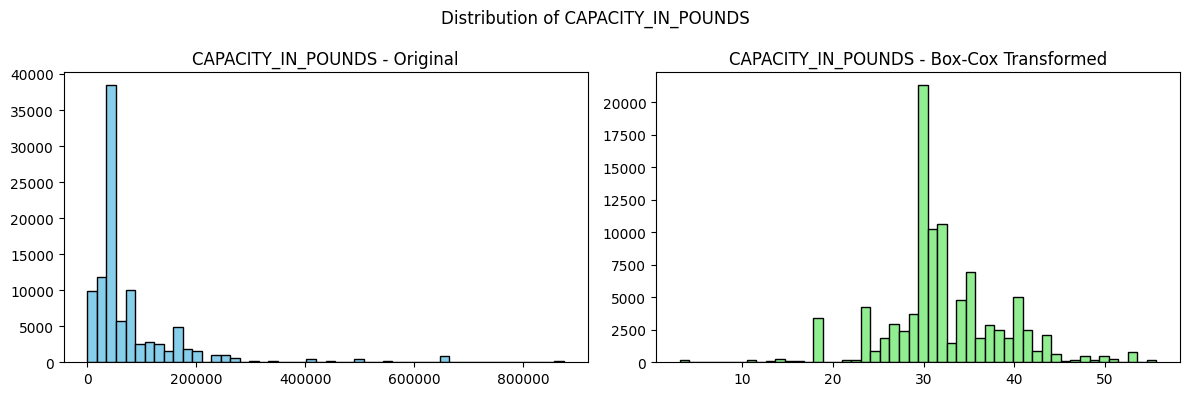

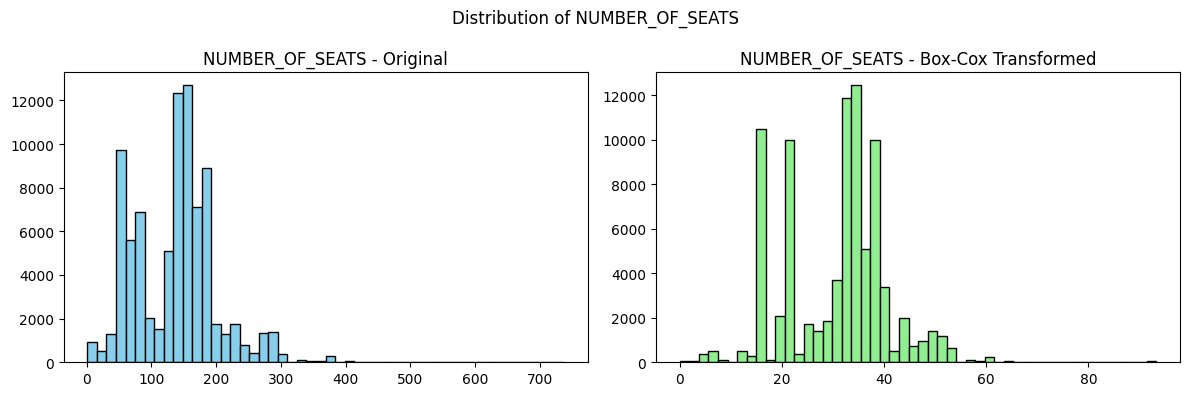

In [17]:
import matplotlib.pyplot as plt
from scipy.stats import boxcox

# Choose columns
cols_to_transform = ['CAPACITY_IN_POUNDS', 'NUMBER_OF_SEATS']

# Plot and transform each
for col in cols_to_transform:
    data = df_clean[col].dropna()

    # Box-Cox requires positive values
    data = data[data > 0]
    transformed_data, _ = boxcox(data)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].hist(data, bins=50, color='skyblue', edgecolor='black')
    axes[0].set_title(f"{col} - Original")

    axes[1].hist(transformed_data, bins=50, color='lightgreen', edgecolor='black')
    axes[1].set_title(f"{col} - Box-Cox Transformed")

    plt.suptitle(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()


I used box-cox transformation to the number of seats and capacity in pounds. I found that the original histograms skewed heavily to the right, which indicates non-normality in the data. After the transformation, the data demonstrated a much more even and symmetric distribution. These transformations could help meet assumptions for modeling methods, such as linear regression that expect normal-like input distributions.

Task 5:

In [23]:
# Get seat percentiles
q1 = df_clean['NUMBER_OF_SEATS'].quantile(0.25)
q2 = df_clean['NUMBER_OF_SEATS'].quantile(0.50)
q3 = df_clean['NUMBER_OF_SEATS'].quantile(0.75)

# Define bins using quantiles
bins = [0, q1, q2, q3, float('inf')]
labels = ['SMALL', 'MEDIUM', 'LARGE', 'XLARGE']

# Apply bins
df_clean['SIZE'] = pd.cut(df_clean['NUMBER_OF_SEATS'], bins=bins, labels=labels, include_lowest=True)

<ipython-input-23-7f08b82b52e8>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['SIZE'] = pd.cut(df_clean['NUMBER_OF_SEATS'], bins=bins, labels=labels, include_lowest=True)


<ipython-input-25-0b3a3dc86d6f>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  operating_counts = df_clean.groupby(['SIZE', 'OPERATING_STATUS']).size().unstack(fill_value=0)


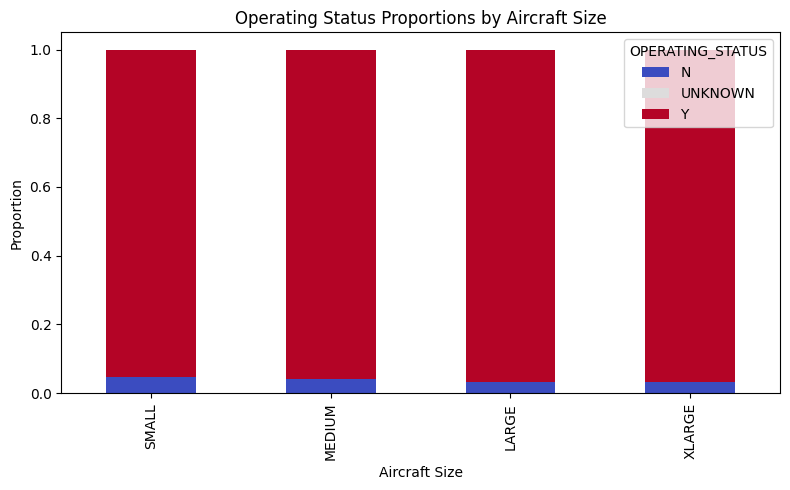

In [25]:
operating_counts = df_clean.groupby(['SIZE', 'OPERATING_STATUS']).size().unstack(fill_value=0)
operating_props = operating_counts.div(operating_counts.sum(axis=1), axis=0)

operating_props.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(8, 5))
plt.title('Operating Status Proportions by Aircraft Size')
plt.ylabel('Proportion')
plt.xlabel('Aircraft Size')
plt.legend(title='OPERATING_STATUS')
plt.tight_layout()
plt.show()

I created a new feature SIZE by dividing NUMBER_OF_SEATS into quartiles:

SMALL: below 25th percentile

MEDIUM: 25th–50th percentile

LARGE: 50th–75th percentile

XLARGE: above 75th percentile

The bar chart shows the proportion of aircraft in each operating status (Y, N, UNKNOWN) across the size bins.
I found a clear trend here. I noticed the larger aircraft (XLARGE) are more likely to be actively operating, while smaller aircraft (SMALL) have a slightly higher share of non-operating (N) or unknown status. This may reflect fleet retirement trends, where smaller planes are more likely to be cycled out or moved to less active roles. It could indicate the direction of airtravel and a focus on trying to fit more and more people on active planes.

<ipython-input-26-73d39c60631c>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aircraft_counts = df_clean.groupby(['SIZE', 'AIRCRAFT_STATUS']).size().unstack(fill_value=0)


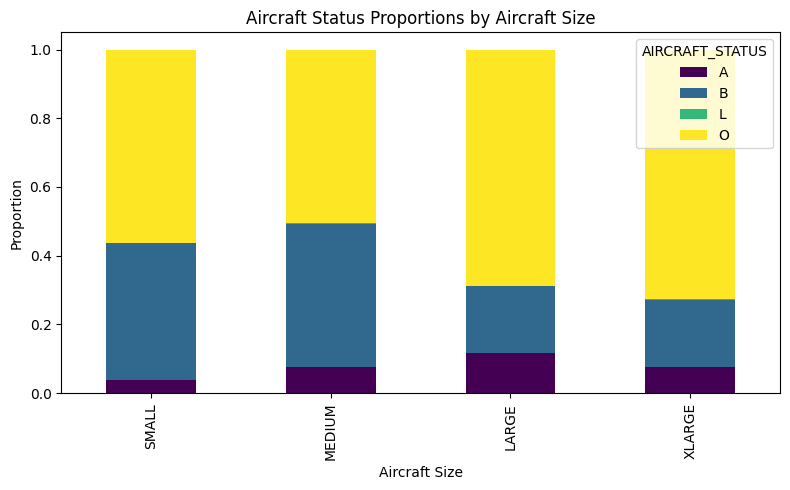

In [26]:
aircraft_counts = df_clean.groupby(['SIZE', 'AIRCRAFT_STATUS']).size().unstack(fill_value=0)
aircraft_props = aircraft_counts.div(aircraft_counts.sum(axis=1), axis=0)

aircraft_props.plot(kind='bar', stacked=True, colormap='viridis', figsize=(8, 5))
plt.title('Aircraft Status Proportions by Aircraft Size')
plt.ylabel('Proportion')
plt.xlabel('Aircraft Size')
plt.legend(title='AIRCRAFT_STATUS')
plt.tight_layout()
plt.show()

I also then examined how aircraft status (AIRCRAFT_STATUS) varies by size quartiles: The "O", which means Operational or Owned, category dominates across all sizes, especially in the XLARGE and LARGE groups. SMALL and MEDIUM aircraft show a more mixed distribution, with noticeable representation in "B" and "A" status categories, which may reflect being in storage, under maintenance, or retired. These results suggest that larger aircraft are more consistently active or held in operational status, while smaller ones may be more frequently shifted to alternate uses or retired earlier. This aligns with the original thoughts from the other chart we looked at. Operational planes skew towards being larger in order to move the maximum number of people.